### 0: Libraries

In [85]:
import requests
import pandas as pd
import geopandas as gpd
import json
from datetime import datetime, timedelta
import os
import glob
import warnings
import psycopg2
import sqlalchemy as db
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from shapely.geometry import Point
import contextily as ctx
from geoalchemy2 import Geometry
from pathlib import Path
import ipywidgets as widgets
from ipywidgets import interact
import unittest
from unittest.mock import patch
# warnings
warnings.filterwarnings('ignore')

# Part1: Data Processing

## 1.1 Downloading 311 and Tree data from API
- Download 311 and Tree data using API and Python Code
- 311 Data set is pretty huge, so we choose to download it seperately into subfiles by year, and merge it at the end

In [10]:
#1. Function (1) Manually Doanload Data from NYC Open Data
def download_data(url, app_token, filename, date_field, start_date, end_date, date_format="%Y-%m-%dT%H:%M:%S", limit=10000):
    """
    Downloads data from the specified NYC Open Data URL within a given date range.

    Args:
        url (str): The API endpoint for the dataset.
        app_token (str): Application token for authenticated access.
        filename (str): The name of the file where the data will be saved.
        date_field (str): The name of the date field in the dataset.
        start_date (datetime): The start date for filtering data.
        end_date (datetime): The end date for filtering data.
        date_format (str): Format of the date fields, defaults to '%Y-%m-%dT%H:%M:%S'.
        limit (int): Number of records to retrieve per request, defaults to 10000.

    Returns:
        None: This function writes the downloaded data to a file and does not return anything.
    """
    
    offset = 0
    start_date_str = start_date.strftime(date_format) # Format the start date
    end_date_str = end_date.strftime(date_format) # Format the end date
    # Construct the query for filtering data by date range
    date_query = f"$where={date_field} between '{start_date_str}' and '{end_date_str}'"
    
    first_batch = True  # Flag to identify the first batch of data
    while True:
        # Construct the full URL with necessary query parameters
        full_url = f"{url}?$$app_token={app_token}&{date_query}&$limit={limit}&$offset={offset}"
        response = requests.get(full_url) # Perform the API request

        if response.status_code == 200:
            data = response.text
            records_retrieved = data.count('\n')  # Count the number of lines (records) retrieved

            if first_batch and records_retrieved > 0:  # If this is the first batch and it contains data
                with open(filename, 'w') as file:
                    file.write(data) # Write data to file, including header
                first_batch = False
            elif records_retrieved > 1:  # For subsequent batches, skip the header row
                with open(filename, 'a') as file:
                    file.write(data.split('\n', 1)[1])  # Append data to file without header

            if records_retrieved < limit + 1:   # Check if all records have been retrieved
                break
            offset += limit # Increment the offset for the next batch
        else:
            print(f"Failed to download data at offset {offset}: Status code {response.status_code}")
            break


In [11]:
#app Toekn: Application token used for authentication
app_token = 'Z8lDMDpdnonlT1RjM5YGII6Ii'
#Data URL: Defines the online API URLs for the datasets
url_311 = 'https://data.cityofnewyork.us/resource/erm2-nwe9.csv'
url_trees = 'https://data.cityofnewyork.us/resource/5rq2-4hqu.csv'

In [22]:
# download tree data: Initiates the download of tree data
# date format "%m/%d/%Y": Setting the date format to month/day/year
download_data(
    url=url_trees,
    app_token=app_token,  
    filename="data/tree_data.csv",
    date_field="created_at",  
    start_date=datetime(2015, 1, 1),
    end_date=datetime(2015, 12, 31),
    date_format="%m/%d/%Y",  
    limit=10000
)

'# download tree data\n# date format "%m/%d/%Y":\ndownload_data(\n    url=url_trees,\n    app_token=app_token,  # Ensure you use the correct app token here\n    filename="data/tree_data.csv",\n    date_field="created_at",  # Ensure this is the correct field name as per the API documentation\n    start_date=datetime(2015, 1, 1),\n    end_date=datetime(2015, 12, 31),\n    date_format="%m/%d/%Y",  # Adjusted date format to match the dataset\n    limit=10000\n)\n'

In [23]:
# download 311 data from 2015.1.1-2023.9.30
#create a new folder to save 311 data by year
subfolder_name = "311_data"
subfolder_path = os.path.join("data", subfolder_name)
if not os.path.exists(subfolder_path):
    os.makedirs(subfolder_path)

'# download 311 data from 2015.1.1-2023.9.30\n#create a new folder to save 311 data by year\nsubfolder_name = "311_data"\nsubfolder_path = os.path.join("data", subfolder_name)\nif not os.path.exists(subfolder_path):\n    os.makedirs(subfolder_path)'

In [24]:
# Run download data function by year
#Year 2015
download_data(
    url_311,
    app_token,  
    filename="data/311_data/311_data_2015.csv",
    date_field="created_date",
    start_date=datetime(2015, 1, 1, 0, 0),  # This represents 2015-01-01 00:00:00 AM
    end_date=datetime(2015, 12, 31, 23, 59, 59),  # This represents 2023-09-30 11:59:59 PM
    date_format="%Y-%m-%dT%H:%M:%S",
    limit=50000
)

'# Run download data function by year\n#Year 2015\ndownload_data(\n    url_311,\n    app_token,  \n    filename="data/311_data/311_data_2015.csv",\n    date_field="created_date",\n    start_date=datetime(2015, 1, 1, 0, 0),  # This represents 2015-01-01 00:00:00 AM\n    end_date=datetime(2015, 12, 31, 23, 59, 59),  # This represents 2023-09-30 11:59:59 PM\n    date_format="%Y-%m-%dT%H:%M:%S",\n    limit=50000\n)\n\n'

In [12]:
# Unit Test (1)
# Path to the file you expect to exist
filename = "data/311_data/311_data_2015.csv"
# Assert that the file exists
assert os.path.exists(filename), "File does not exist"

In [25]:
# Year 2016
download_data(
    url_311,
    app_token,  
    filename="data/311_data/311_data_2016.csv",
    date_field="created_date",
    start_date=datetime(2016, 1, 1, 0, 0),  
    end_date=datetime(2016, 12, 31, 23, 59, 59),  
    date_format="%Y-%m-%dT%H:%M:%S",
    limit=50000
)

'# Year 2016\ndownload_data(\n    url_311,\n    app_token,  \n    filename="data/311_data/311_data_2016.csv",\n    date_field="created_date",\n    start_date=datetime(2016, 1, 1, 0, 0),  # This represents 2015-01-01 00:00:00 AM\n    end_date=datetime(2016, 12, 31, 23, 59, 59),  # This represents 2023-09-30 11:59:59 PM\n    date_format="%Y-%m-%dT%H:%M:%S",\n    limit=50000\n)'

In [26]:
# Year 2017
download_data(
    url_311,
    app_token,  
    filename="data/311_data/311_data_2017.csv",
    date_field="created_date",
    start_date=datetime(2017, 1, 1, 0, 0),  
    end_date=datetime(2017, 12, 31, 23, 59, 59),  
    date_format="%Y-%m-%dT%H:%M:%S",
    limit=50000
)

'# Year 2017\ndownload_data(\n    url_311,\n    app_token,  \n    filename="data/311_data/311_data_2017.csv",\n    date_field="created_date",\n    start_date=datetime(2017, 1, 1, 0, 0),  # This represents 2015-01-01 00:00:00 AM\n    end_date=datetime(2017, 12, 31, 23, 59, 59),  # This represents 2023-09-30 11:59:59 PM\n    date_format="%Y-%m-%dT%H:%M:%S",\n    limit=50000\n)'

In [27]:
# Year 2018
download_data(
    url_311,
    app_token,  
    filename="data/311_data/311_data_2018.csv",
    date_field="created_date",
    start_date=datetime(2018, 1, 1, 0, 0),  
    end_date=datetime(2018, 12, 31, 23, 59, 59),  
    date_format="%Y-%m-%dT%H:%M:%S",
    limit=50000
)

'# Year 2018\ndownload_data(\n    url_311,\n    app_token,  \n    filename="data/311_data/311_data_2018.csv",\n    date_field="created_date",\n    start_date=datetime(2018, 1, 1, 0, 0),  # This represents 2015-01-01 00:00:00 AM\n    end_date=datetime(2018, 12, 31, 23, 59, 59),  # This represents 2023-09-30 11:59:59 PM\n    date_format="%Y-%m-%dT%H:%M:%S",\n    limit=50000\n)'

In [28]:
# Year 2019
download_data(
    url_311,
    app_token,  
    filename="data/311_data/311_data_2019.csv",
    date_field="created_date",
    start_date=datetime(2019, 1, 1, 0, 0),  
    end_date=datetime(2019, 12, 31, 23, 59, 59),  
    date_format="%Y-%m-%dT%H:%M:%S",
    limit=50000
)

'# Year 2019\ndownload_data(\n    url_311,\n    app_token,  \n    filename="data/311_data/311_data_2019.csv",\n    date_field="created_date",\n    start_date=datetime(2019, 1, 1, 0, 0),  # This represents 2015-01-01 00:00:00 AM\n    end_date=datetime(2019, 12, 31, 23, 59, 59),  # This represents 2023-09-30 11:59:59 PM\n    date_format="%Y-%m-%dT%H:%M:%S",\n    limit=50000\n)'

In [29]:
# Year 2020
download_data(
    url_311,
    app_token,  
    filename="data/311_data/311_data_2020.csv",
    date_field="created_date",
    start_date=datetime(2020, 1, 1, 0, 0),  
    end_date=datetime(2020, 12, 31, 23, 59, 59),  
    date_format="%Y-%m-%dT%H:%M:%S",
    limit=50000
)

'# Year 2020\ndownload_data(\n    url_311,\n    app_token,  \n    filename="data/311_data/311_data_2020.csv",\n    date_field="created_date",\n    start_date=datetime(2020, 1, 1, 0, 0),  # This represents 2015-01-01 00:00:00 AM\n    end_date=datetime(2020, 12, 31, 23, 59, 59),  # This represents 2023-09-30 11:59:59 PM\n    date_format="%Y-%m-%dT%H:%M:%S",\n    limit=50000\n)'

In [30]:
# Year 2021
download_data(
    url_311,
    app_token,  
    filename="data/311_data/311_data_2021.csv",
    date_field="created_date",
    start_date=datetime(2021, 1, 1, 0, 0),  
    end_date=datetime(2021, 12, 31, 23, 59, 59),  
    date_format="%Y-%m-%dT%H:%M:%S",
    limit=50000
)

'# Year 2021\ndownload_data(\n    url_311,\n    app_token,  \n    filename="data/311_data/311_data_2021.csv",\n    date_field="created_date",\n    start_date=datetime(2021, 1, 1, 0, 0),  # This represents 2015-01-01 00:00:00 AM\n    end_date=datetime(2021, 12, 31, 23, 59, 59),  # This represents 2023-09-30 11:59:59 PM\n    date_format="%Y-%m-%dT%H:%M:%S",\n    limit=50000\n)'

In [31]:
# Year 2022
download_data(
    url_311,
    app_token,  
    filename="data/311_data/311_data_2022.csv",
    date_field="created_date",
    start_date=datetime(2022, 1, 1, 0, 0), 
    end_date=datetime(2022, 12, 31, 23, 59, 59),  
    date_format="%Y-%m-%dT%H:%M:%S",
    limit=50000
)

'# Year 2022\ndownload_data(\n    url_311,\n    app_token,  \n    filename="data/311_data/311_data_2022.csv",\n    date_field="created_date",\n    start_date=datetime(2022, 1, 1, 0, 0),  # This represents 2015-01-01 00:00:00 AM\n    end_date=datetime(2022, 12, 31, 23, 59, 59),  # This represents 2023-09-30 11:59:59 PM\n    date_format="%Y-%m-%dT%H:%M:%S",\n    limit=50000\n)'

In [32]:
# Year 2023
download_data(
    url_311,
    app_token,  
    filename="data/311_data/311_data_2023.csv",
    date_field="created_date",
    start_date=datetime(2023, 1, 1, 0, 0),  
    end_date=datetime(2023, 9, 30, 23, 59, 59),  
    date_format="%Y-%m-%dT%H:%M:%S",
    limit=50000
)

'# Year 2023\ndownload_data(\n    url_311,\n    app_token,  \n    filename="data/311_data/311_data_2023.csv",\n    date_field="created_date",\n    start_date=datetime(2023, 1, 1, 0, 0),  # This represents 2015-01-01 00:00:00 AM\n    end_date=datetime(2023, 9, 30, 23, 59, 59),  # This represents 2023-09-30 11:59:59 PM\n    date_format="%Y-%m-%dT%H:%M:%S",\n    limit=50000\n)'

## 1.2 Cleaning & Filtering


### 1.2.1 Data Description & Columns to keep

Prior to developing data cleaning functions, we conducted a thorough examination of each dataset's types and descriptions, as well as the query and visualization requirements of our project. The following list details the columns we have chosen to retain. Each column is accompanied by its description and original data type.

##### *Zillow Rent Data Description

| Column Name                  | Description                                                                          | Type        |
|------------------------------|--------------------------------------------------------------------------------------|-------------|
| RegionID                     | Used for pandas, an identifier for the region                                         | Integer     |
| RegionName                   | Same as postcode, matches 'Incident Zip' in other datasets, link with latitude and longitude | Integer     |
| City                         | Different cities, for later filtering to New York                                     | Object      |
| Average Housing Price Columns| Keep all columns related to average housing prices for each region                   | Float64     |


##### *311 Data
https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9

311 Service Requests from 2010 to Present
This dataset comprises all 311 Service Requests from 2010 to the present day, updated daily. It provides a comprehensive overview of non-emergency requests and complaints to New York City's 311 service.


| Column Name    | Description                                                              | Type        |
|----------------|--------------------------------------------------------------------------|-------------|
| unique_key     | Unique identifier of a Service Request (SR) in the open data set         | Plain Text  |
| created_date   | Date SR was created                                                      | Date & Time |
| complaint_type | First level of a hierarchy identifying the topic of the incident or condition | Plain Text  |
| incident_zip   | Incident location zip code, provided by geo validation                   | Plain Text  |
| latitude       | Geo based Latitude of the incident location                              | Number      |
| longitude      | Geo based Longitude of the incident location                             | Number      |




##### *Tree Data Description
https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/uvpi-gqnh


2015 Street Tree Census, conducted by volunteers and staff organized by NYC Parks & Recreation and partner organizations. Tree data collected includes tree species, diameter and perception of health. Accompanying blockface data is available indicating status of data collection and data release citywide.


| Column Name   | Description                                                                   | Type       |
|---------------|-------------------------------------------------------------------------------|------------|
| tree_id       | Unique identification number for each tree point                              | Integer     |
| status        | Indicates whether the tree is alive, standing dead, or a stump               | Plain Text |
| created_at  | Date and time when the tree data was created                                  | Plain Text |
| zipcode       | Five-digit zipcode in which tree is located                                  | Integer |
| latitude      | Latitude of point, in decimal degrees                                        | Number     |
| longitude     | Longitude of point, in decimal degrees                                       | Number     |
| health        | Indicates the user's perception of tree health                               | Plain Text |
| spc_common    | Common name for species, e.g., "red maple"                                   | Plain Text |


#### *Zipcode Data Description
| Column Name | Description                                | Type    |
|-------------|--------------------------------------------|---------|
| ZIPCODE     | The postal code corresponding to the area  | Plain Text |
| geometry    | Geometrical data representing the area     | Geometry |






### 1.2.2 Data Cleaning Functions and Processing

This section outlines the primary steps undertaken in the data cleaning and processing phase of our project. While these are the key actions, it is important to note that additional minor procedures were also employed to ensure data integrity and usability:

1. **Column Retention Function**: Developed a function to retain specific columns in our datasets, focusing our analysis on pertinent data.

2. **Standardization of Column Titles**: Converted all column titles to lowercase for uniformity, easing data manipulation and consistency.

3. **Column Validation Checks**: Performed rigorous checks to validate columns against specific criteria, including the accuracy of zip codes and geographical coordinates.

4. **Zip Code Standardization**: Uniformly transformed all zip code data to integer type, enhancing consistency in geographical data.

5. **Coordinate System Uniformity**: Standardized the coordinate system of all datasets to SRID 3857 format, crucial for precise geographical mapping and analysis.

6. **Filtering New York Areas Using NYC Zipcode Dataset**: Employed the NYC zipcode dataset to filter out data pertaining only to New York areas, ensuring geographic relevance.

7. **Unique Identifier Assignment**: Assigned IDs from each dataset (except Zillow rent) as unique identifiers, guaranteeing the distinctiveness of each entry.

8. **Removal of Empty Rows**: Eliminated rows with empty or null values to maintain data quality and reliability.

9. **Subfile Processing for 311 Data**: Processed 311 data in subfiles for focused cleaning, followed by consolidation.

10. **Merging Function for 311 Data**: Created a function to merge all 311 data subfiles, facilitating comprehensive analysis and easier handling.

In addition to these major steps, other minor but critical tasks were also performed to further refine and prepare our datasets for analysis and visualization. Each step, major or minor, contributes significantly to the overall data quality and the success of our project.


#### 1.2.2.1 Functions aiding data cleaning

In [2]:
# Function (2) create a remove_column function for deleting the unnecessary columns

def remove_column(df, keep_columns, include_date_columns=False, date_pattern=r'\d{4}-\d{2}-\d{2}'):
    """
    Removes columns from a DataFrame, retaining only the specified columns and optionally any date columns.

    Parameters:
    - df (pd.DataFrame): The DataFrame to be modified.
    - keep_columns (list of str): A list of column names to retain in the DataFrame.
    - include_date_columns (bool, optional): Flag to include columns with date format. Defaults to False.
    - date_pattern (str, optional): Regular expression pattern to identify date columns. Used when 'include_date_columns' is True. Default pattern matches 'YYYY-MM-DD'.

    Returns:
    - pd.DataFrame: The modified DataFrame with only the specified columns retained.
    
    Example:
    >>> df = pd.DataFrame(...)
    >>> new_df = remove_column(df, ['column1', 'column2'], include_date_columns=True)
    """
    # Combine specified columns with date columns if needed
    all_columns_to_keep = keep_columns

    # If including date columns, append them to the list of columns to keep
    if include_date_columns:
        # Identify date columns using the regex pattern
        date_columns = df.columns[df.columns.str.contains(date_pattern)]
        all_columns_to_keep += date_columns.tolist()

    # Return the DataFrame with only the specified columns retained
    return df.loc[:, all_columns_to_keep]

In [3]:
# Unit test (2)
# Create a sample DataFrame
df = pd.DataFrame({
    'column1': [1, 2, 3],
    'column2': [4, 5, 6],
    'date_column': pd.to_datetime(['2020-01-01', '2020-01-02', '2020-01-03']),
    'irrelevant_column': ['x', 'y', 'z']
})

# Run the function with a test case
keep_columns = ['column1', 'column2']
new_df = remove_column(df, keep_columns, include_date_columns=True)

# Test assertions
assert 'column1' in new_df.columns, "column1 is not in the DataFrame"
assert 'column2' in new_df.columns, "column2 is not in the DataFrame"
assert 'date_column' not in new_df.columns, "date_column should not be retained in the DataFrame based on the current function implementation"
assert 'irrelevant_column' not in new_df.columns, "irrelevant_column should have been removed from the DataFrame"
assert new_df.shape[1] == 2, "The number of columns in the DataFrame should be two"


In [4]:
# Function (3),(4) create functions to check valid longitute and latitute
def is_valid_latitude(lat):
    """
    Checks if the provided latitude value is valid.

    Parameters:
    - lat (str): The latitude value to be checked.

    Returns:
    - bool: True if the latitude is valid, False otherwise.

    A valid latitude is a number between -90 and 90.
    Non-numeric values or latitudes outside this range will return False.
    """
    
    try:
        # Check if latitude is within the valid range
        return -90 <= float(lat) <= 90
    except ValueError:
        # Return False if latitude is not a number
        return False

def is_valid_longitude(lon):
    """
    Checks if the provided longitude value is valid.

    Parameters:
    - lon (str): The longitude value to be checked.

    Returns:
    - bool: True if the longitude is valid, False otherwise.

    A valid longitude is a number between -180 and 180.
    Non-numeric values or longitudes outside this range will return False.
    """
    try:
        # Check if longitude is within the valid range
        return -180 <= float(lon) <= 180
    except ValueError:
        # Return False if longitude is not a number
        return False

In [5]:
# Unit Test (3) cases for is_valid_latitude
assert is_valid_latitude("45"), "45 should be a valid latitude"
assert is_valid_latitude("-90"), "-90 should be a valid latitude"
assert is_valid_latitude("90"), "90 should be a valid latitude"
assert not is_valid_latitude("100"), "100 should not be a valid latitude"
assert not is_valid_latitude("-91"), "-91 should not be a valid latitude"
assert not is_valid_latitude("not_a_number"), "'not_a_number' should not be a valid latitude"

In [6]:
# Unit Test (4) cases for is_valid_longitude
assert is_valid_longitude("90"), "90 should be a valid longitude"
assert is_valid_longitude("-180"), "-180 should be a valid longitude"
assert is_valid_longitude("180"), "180 should be a valid longitude"
assert not is_valid_longitude("190"), "190 should not be a valid longitude"
assert not is_valid_longitude("-181"), "-181 should not be a valid longitude"
assert not is_valid_longitude("not_a_number"), "'not_a_number' should not be a valid longitude"

#### 1.2.2.2 Functions performing data cleaning and filtering for each datafile

In [7]:
# 1. zipcode
# Function (5) Create a clean and filter function for zipcode data
def process_zipcode_shapefile(shapefile_path):
    """
    Processes and cleans the zipcode shapefile to prepare it for analysis.

    Args:
    - shapefile_path (str): Path to the zipcode shapefile.

    Returns:
    - gpd.GeoDataFrame: A GeoDataFrame containing the cleaned and processed zipcode data.

    This function performs several steps to clean the data, including selecting essential columns,
    removing duplicates, filtering out missing values, renaming and reformatting columns, 
    and adjusting geometries to a common Coordinate Reference System (CRS).
    """
    # Step 1: Reading the shapefile
    zipcode_gdf = gpd.read_file(shapefile_path)
    
    # Step 2: Selecting essential columns
    columns_required = ['ZIPCODE', 'geometry']
    zipcode_gdf = zipcode_gdf[columns_required]
    
    
    # Step 3: Remove duplicates
    zipcode_gdf.drop_duplicates(subset=['ZIPCODE'], inplace=True)
    
    
    # Step 4: Filtering out rows with missing values in critical columns
    zipcode_gdf.dropna(subset=['ZIPCODE', 'geometry'], inplace=True)
    
    
    # Step 5: Renaming and reformatting the columns
    # Renaming 'ZIPCODE' to 'zipcode' for consistency
    zipcode_gdf.rename(columns={'ZIPCODE': 'zipcode'}, inplace=True)
    
        
    # Converting the 'zipcode' to string format for standardization
    zipcode_gdf['zipcode'] = zipcode_gdf['zipcode'].astype(int)  # Convert zipcode to integer
    
    
    # check if it lasts with 5 digits
    zipcode_gdf = zipcode_gdf[zipcode_gdf['zipcode'].apply(lambda x: str(x).isdigit() and len(str(x)) == 5)]

    # Step 6: Adjusting geometries to a common CRS
    # Transforming geometries to the web mercator projection for mapping compatibility
    common_crs = "EPSG:3857"
    zipcode_gdf.to_crs(common_crs, inplace=True)
    
    # Ensuring all column names are in lowercase
    zipcode_gdf.columns = map(str.lower, zipcode_gdf.columns)
    
    return zipcode_gdf

In [8]:
# 2.1 311 Data
# Function (6)
def clean_filter_311(filename, nyc_zipcodes):
    """
    Cleans and filters 311 complaint data to retain only relevant information and valid entries.

    Args:
    - filename (str): Path to the CSV file containing 311 data.
    - nyc_zipcodes (list of int): List of valid NYC zip codes for filtering.

    Returns:
    - gpd.GeoDataFrame: A GeoDataFrame containing the cleaned and filtered 311 complaint data.

    The function includes data loading, column selection, data validation, normalization of column names and types, 
    and transformation of data into a geospatial format.
    """
    # Step 0: Load data
    df = pd.read_csv(filename)

    # Step 1: Select necessary columns
    columns_to_keep_311 = ['unique_key', 'created_date', 'complaint_type', 'incident_zip', 'latitude', 'longitude']
    df = df[columns_to_keep_311]

    # Step 2: Remove invalid and duplicate data
    # Remove duplicates and confirm unique_key
    df = df.drop_duplicates(subset='unique_key')
    df = df[df['unique_key'].notna() & df['unique_key'].apply(lambda x: str(x).isdigit())]

    # Remove rows with NaN in critical columns
    df = df.dropna(subset=['incident_zip', 'latitude', 'longitude', 'created_date'])

    # Check if latitude and longitude are valid
    df = df[df['latitude'].apply(is_valid_latitude) & df['longitude'].apply(is_valid_longitude)]

    # Step 3: Normalize Column Names, Column Types
    
    # Standardize 'incident_zip' to integer and filter by NYC zipcodes
    df['incident_zip'] = df['incident_zip'].astype(int)
    df = df[df['incident_zip'].isin(nyc_zipcodes)]

    # Rename and reformat columns for consistency
    df.rename(columns={'unique_key': 'complaint_id', 'created_date': 'date', 'incident_zip': 'zipcode'}, inplace=True)
    df['complaint_id'] = df['complaint_id'].astype(int)

    # Convert 'date' column to datetime format
    df['date'] = pd.to_datetime(df['date'], errors='coerce').dt.strftime('%Y-%m-%d')

    # Drop rows with null values post transformations
    df = df.dropna()

    # Step 4: Normalize the SRID of any geometry
    
    # Convert DataFrame to GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']))
    gdf.set_crs("EPSG:4326", inplace=True)
    gdf.to_crs("EPSG:3857", inplace=True)

    return gdf


In [9]:
# 2.2 Function (7) to clean and merge 311 data
def clean_merge_311_data(folder_path, file_prefix, years,nyc_zipcodes):
    """
    Cleans individual 311 data files for specified years and merges them into a single DataFrame.

    Args:
    - folder_path (str): Path to the folder containing 311 data files.
    - file_prefix (str): Prefix of the 311 data filenames.
    - years (list of int): List of years for which the 311 data needs to be cleaned and merged.
    - nyc_zipcodes (list of int): List of valid NYC zip codes for filtering.

    Returns:
    - pd.DataFrame: A merged DataFrame containing cleaned and consolidated 311 data for the specified years.

    The function iteratively cleans each year's data file using 'clean_filter_311' and then merges them into one DataFrame.
    """
    
    # List to hold cleaned DataFrames for each year
    cleaned_dfs = []
    
    # Iterate over each year, clean the corresponding 311 data file, and add it to the list
    for year in years:
        filename = f"{folder_path}/{file_prefix}{year}.csv"
        cleaned_df = clean_filter_311(filename,nyc_zipcodes)
        cleaned_dfs.append(cleaned_df)
    
    # # Merge all cleaned DataFrames into a single DataFrame
    merged_df = pd.concat(cleaned_dfs, ignore_index=True)
    return merged_df

In [10]:
# 3. Function (8) to clean and filter tree data
def clean_filter_tree(filename, nyc_zipcodes):
    """
    Cleans and filters tree data, retaining only the relevant information and valid entries.

    Args:
    - filename (str): Path to the CSV file containing tree data.
    - nyc_zipcodes (list of int): List of valid NYC zip codes for filtering.

    Returns:
    - gpd.GeoDataFrame: A GeoDataFrame containing the cleaned and filtered tree data.

    This function includes loading data, selecting necessary columns, removing invalid and duplicate data,
    and transforming the data into a geospatial format.
    """
    # Load data
    df = pd.read_csv(filename)

    # Select the necessary columns for analysis
    columns_to_keep_tree = ['tree_id', 'status', 'zipcode', 'latitude', 'longitude', 'health', 'spc_common', 'created_at']
    df = df[columns_to_keep_tree]

    # Remove duplicate entries and ensure tree IDs are valid (tree id as uid)
    df = df.drop_duplicates(subset='tree_id')
    df = df[df['tree_id'].notna() & df['tree_id'].apply(lambda x: str(x).isdigit())]

    # Drop rows with missing values in critical columns before type conversions
    df = df.dropna(subset=['zipcode', 'latitude', 'longitude', 'created_at'])

    # Standardize 'zipcode' to integer and filter by NYC zipcodes
    df['zipcode'] = df['zipcode'].astype(int)
    df = df[df['zipcode'].isin(nyc_zipcodes)]

    # Validate latitude and longitude values
    df = df[df['latitude'].apply(is_valid_latitude) & df['longitude'].apply(is_valid_longitude)]

    # Rename and reformat columns for consistency
    df.rename(columns={'created_at': 'date', 'spc_common': 'species'}, inplace=True)

    # Convert 'date' column to datetime format
    df['date'] = pd.to_datetime(df['date'], errors='coerce').dt.strftime('%Y-%m-%d')

    # Convert to GeoDataFrame and normalize SRID
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']))
    gdf.set_crs("EPSG:4326", inplace=True)
    gdf.to_crs("EPSG:3857", inplace=True)

    return gdf


In [11]:
# 4. Function (9) to clean and filter zillow rent data
def clean_filter_rent(filename, nyc_zipcodes):
    """
    Cleans and filters Zillow rent data, retaining only the relevant information for NYC regions.

    Args:
    - filename (str): Path to the CSV file containing Zillow rent data.
    - nyc_zipcodes (list of int): List of valid NYC zip codes for filtering.

    Returns:
    - pd.DataFrame: A DataFrame containing the cleaned and filtered Zillow rent data.

    This function includes loading the data, dropping unnecessary columns, renaming columns, 
    and transforming the data format for analysis.
    """
    # Load data
    df = pd.read_csv(filename)
    
    # Drop 'City' column
    df = df.drop(columns=['City'])
    
    # Rename 'RegionID' and 'RegionName' columns for standardization
    df.rename(columns={'RegionID': 'region_id', 'RegionName': 'zipcode'}, inplace=True)
    
    # Remove duplicate entries based on 'region_id'
    df = df.drop_duplicates(subset='region_id')
    
    # Drop rows with NA values in 'zipcode' column
    df = df.dropna(subset=['zipcode'])

    # Ensure that the 'zipcode' is an integer format for consistency
    df['zipcode'] = df['zipcode'].astype(int)

    # Filter the DataFrame to include only rows with NYC zip codes
    df = df[df['zipcode'].isin(nyc_zipcodes)]
    
    # Transpose the dataframe: each date becomes a row
    id_vars = ['region_id', 'zipcode']
    value_vars = [col for col in df.columns if col not in id_vars and col.startswith('20')]
    df_melted = df.melt(id_vars=id_vars, value_vars=value_vars, var_name='date', value_name='rent')
    
    # Add 'rent_id' column as an identifier to uniquely identify each rent entry
    df_melted.insert(0, 'rent_id', range(1, 1 + len(df_melted)))
    
    # Filter out rows with NaN values in any column
    df_melted = df_melted.dropna()
    
    return df_melted


In [12]:
#311 data input arguments
folder_path = "data/311_data"
file_prefix = "311_data_"
years = ['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']

# Function (10) load all data
def load_all_data():
    """
    Loads and processes all datasets: Zipcode, 311, Tree, and Zillow Rent data.

    This function first processes the NYC zipcode data to create a list of valid NYC zipcodes. 
    It then uses this list to filter and process the 311, Tree, and Zillow Rent datasets.

    Returns:
    Tuple: Containing GeoDataFrames for Zipcode and 311 data, and DataFrames for Tree and Zillow Rent data.
    """
    # Process the zipcode shapefile to create a GeoDataFrame of NYC zipcodes
    geodf_zipcode_data = process_zipcode_shapefile("data/nyc_zipcodes/ZIP_CODE_040114.shp")
    
    # Extract a list of valid NYC zipcodes from the processed zipcode data
    nyc_zipcodes = geodf_zipcode_data['zipcode'].tolist()
    
     # Clean and merge 311 data for the specified years using the list of NYC zipcodes
    geodf_311_data = clean_merge_311_data(folder_path, file_prefix, years,nyc_zipcodes)
    
    # Clean and filter tree data using the list of NYC zipcodes
    geodf_tree_data = clean_filter_tree('data/tree_data.csv',nyc_zipcodes)
    
    # Clean and filter Zillow Rent data using the list of NYC zipcodes
    df_zillow_data = clean_filter_rent('data/zillow_rent_data.csv',nyc_zipcodes)
    
    # Return all processed datasets
    return (
        geodf_zipcode_data,
        geodf_311_data,
        geodf_tree_data,
        df_zillow_data
    )

In [13]:
# Call the load_all_data function to load and process all datasets
# The function returns four datasets: Zipcode, 311, Tree, and Zillow Rent data
# Each dataset is stored in a separate variable for further analysis

geodf_zipcode_data, geodf_311_data, geodf_tree_data, df_zillow_data = load_all_data()

In [14]:
# Unit test (5) for zipcode data
assert isinstance(geodf_zipcode_data, gpd.GeoDataFrame), "The result should be a GeoDataFrame"
assert 'zipcode' in geodf_zipcode_data.columns, "zipcode column is missing"
assert geodf_zipcode_data['zipcode'].dtype == int, "zipcode column should be of integer type"
assert len(geodf_zipcode_data['zipcode'].unique()) == len(geodf_zipcode_data), "There should be no duplicate zipcodes"
assert geodf_zipcode_data.isnull().sum().sum() == 0, "There should be no missing values"
assert geodf_zipcode_data.crs.to_string() == "EPSG:3857", "CRS should be EPSG:3857"
assert all(len(str(z)) == 5 for z in geodf_zipcode_data['zipcode']), "All zipcodes should have 5 digits"

In [15]:
# Unit test (6) for 311 data
assert isinstance(geodf_311_data, gpd.GeoDataFrame), "The result should be a GeoDataFrame"
assert 'zipcode' in geodf_311_data.columns, "zipcode column is missing in 311 data"
assert geodf_311_data['zipcode'].dtype == int, "zipcode column should be of integer type in 311 data"
assert geodf_311_data.isnull().sum().sum() == 0, "There should be no missing values in 311 data"
assert geodf_311_data.crs.to_string() == "EPSG:3857", "CRS of 311 data should be EPSG:3857"
assert all(len(str(z)) == 5 for z in geodf_311_data['zipcode']), "All zipcodes in 311 data should have 5 digits"

In [16]:
# Unit test (7) for clean_merge function
assert isinstance(geodf_311_data, pd.DataFrame), "The result should be a DataFrame"
assert 'zipcode' in geodf_311_data.columns, "zipcode column is missing in merged 311 data"
assert geodf_311_data['zipcode'].dtype == int, "zipcode column should be of integer type in merged 311 data"
assert geodf_311_data.isnull().sum().sum() == 0, "There should be no missing values in merged 311 data"
assert all(len(str(z)) == 5 for z in geodf_311_data['zipcode']), "All zipcodes in merged 311 data should have 5 digits"

In [17]:
# Unit test (8) for tree data function
assert isinstance(geodf_tree_data, gpd.GeoDataFrame), "The result should be a GeoDataFrame"
assert 'zipcode' in geodf_tree_data.columns, "zipcode column is missing in tree data"
assert geodf_tree_data['zipcode'].dtype == int, "zipcode column should be of integer type in tree data"
assert geodf_tree_data.crs.to_string() == "EPSG:3857", "CRS of tree data should be EPSG:3857"
assert all(len(str(z)) == 5 for z in geodf_tree_data['zipcode']), "All zipcodes in tree data should have 5 digits"

In [18]:
# Unit test (9) for zillow data function
assert isinstance(df_zillow_data, pd.DataFrame), "The result should be a DataFrame"
assert 'zipcode' in df_zillow_data.columns, "zipcode column is missing in Zillow rent data"
assert df_zillow_data['zipcode'].dtype == int, "zipcode column should be of integer type in Zillow rent data"
assert df_zillow_data.isnull().sum().sum() == 0, "There should be no missing values in Zillow rent data"
assert 'date' in df_zillow_data.columns, "date column is missing in Zillow rent data"
assert 'rent' in df_zillow_data.columns, "rent column is missing in Zillow rent data"
assert 'rent_id' in df_zillow_data.columns, "rent_id column is missing in Zillow rent data"

In [19]:
# Unit test (10) for load all data
assert isinstance(geodf_zipcode_data, gpd.GeoDataFrame), "Zipcode data should be a GeoDataFrame"
assert isinstance(geodf_311_data, gpd.GeoDataFrame), "311 data should be a GeoDataFrame"
assert isinstance(geodf_tree_data, gpd.GeoDataFrame), "Tree data should be a GeoDataFrame"
assert isinstance(df_zillow_data, pd.DataFrame), "Zillow Rent data should be a DataFrame"


assert not geodf_zipcode_data.empty, "Zipcode data should not be empty"
assert not geodf_311_data.empty, "311 data should not be empty"
assert not geodf_tree_data.empty, "Tree data should not be empty"
assert not df_zillow_data.empty, "Zillow Rent data should not be empty"


In [20]:
# Show first 5 entries about each dataframe
geodf_zipcode_data.head()

,zipcode,geometry
0,11436,"POLYGON ((-8216029.470 4965682.769, -8216011.9..."
1,11213,"POLYGON ((-8230673.455 4965216.008, -8230392.3..."
2,11212,"POLYGON ((-8226837.796 4963911.170, -8226758.2..."
3,11225,"POLYGON ((-8232963.912 4963884.338, -8232717.3..."
4,11218,"POLYGON ((-8234534.400 4960940.544, -8234516.0..."


In [21]:
geodf_zipcode_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 247 entries, 0 to 262
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   zipcode   247 non-null    int64   
 1   geometry  247 non-null    geometry
dtypes: geometry(1), int64(1)
memory usage: 5.8 KB


In [22]:
geodf_311_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 23026041 entries, 0 to 23026040
Data columns (total 7 columns):
 #   Column          Dtype   
---  ------          -----   
 0   complaint_id    int64   
 1   date            object  
 2   complaint_type  object  
 3   zipcode         int64   
 4   latitude        float64 
 5   longitude       float64 
 6   geometry        geometry
dtypes: float64(2), geometry(1), int64(2), object(2)
memory usage: 1.2+ GB


In [23]:
geodf_311_data.head()

,complaint_id,date,complaint_type,zipcode,latitude,longitude,geometry
0,32310363,2015-12-31,Noise - Street/Sidewalk,10034,40.865682,-73.923501,POINT (-8229126.484 4992549.863)
1,32309934,2015-12-31,Blocked Driveway,11105,40.775945,-73.915094,POINT (-8228190.619 4979349.608)
2,32306007,2015-12-31,Noise - Residential,10302,40.632882,-74.132033,POINT (-8252340.140 4958341.738)
3,32309159,2015-12-31,Blocked Driveway,10458,40.870325,-73.888525,POINT (-8225232.939 4993233.335)
4,32309493,2015-12-31,Noise - Residential,10002,40.710478,-73.986571,POINT (-8236147.417 4969730.548)


In [28]:
geodf_tree_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 682853 entries, 0 to 683787
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   tree_id    682853 non-null  int64   
 1   status     682853 non-null  object  
 2   zipcode    682853 non-null  int64   
 3   latitude   682853 non-null  float64 
 4   longitude  682853 non-null  float64 
 5   health     651240 non-null  object  
 6   species    651237 non-null  object  
 7   date       682853 non-null  object  
 8   geometry   682853 non-null  geometry
dtypes: float64(2), geometry(1), int64(2), object(4)
memory usage: 52.1+ MB


In [29]:
geodf_tree_data.head()

,tree_id,status,zipcode,latitude,longitude,health,species,date,geometry
0,180683,Alive,11375,40.723092,-73.844215,Fair,red maple,2015-08-27,POINT (-8220300.436 4971583.163)
1,200540,Alive,11357,40.794111,-73.818679,Fair,pin oak,2015-09-03,POINT (-8217457.809 4982020.303)
2,204026,Alive,11211,40.717581,-73.936608,Good,honeylocust,2015-09-05,POINT (-8230585.520 4970773.712)
3,204337,Alive,11211,40.713537,-73.934456,Good,honeylocust,2015-09-05,POINT (-8230346.012 4970179.889)
4,189565,Alive,11215,40.666778,-73.975979,Good,American linden,2015-08-30,POINT (-8234968.356 4963315.009)


In [30]:
df_zillow_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9041 entries, 5 to 15329
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   rent_id    9041 non-null   int64  
 1   region_id  9041 non-null   int64  
 2   zipcode    9041 non-null   int64  
 3   date       9041 non-null   object 
 4   rent       9041 non-null   float64
dtypes: float64(1), int64(3), object(1)
memory usage: 423.8+ KB


In [31]:
df_zillow_data.head()

,rent_id,region_id,zipcode,date,rent
5,6,62037,11226,2015-01-31,1944.609891
7,8,61639,10025,2015-01-31,3068.951823
13,14,62017,11206,2015-01-31,2482.829299
14,15,62032,11221,2015-01-31,2125.738807
20,21,62045,11235,2015-01-31,1687.789898


# Part2: Storing Data

## 2.1 Create Databases

In [24]:
!createdb FINAL_PROJECT_4511
!psql --dbname FINAL_PROJECT_4511 -c 'CREATE EXTENSION if NOT EXISTS postgis;'

createdb: error: database creation failed: ERROR:  database "FINAL_PROJECT_4511" already exists
NOTICE:  extension "postgis" already exists, skipping
CREATE EXTENSION


In [25]:
"""conn = psycopg2.connect(
    database="FINAL_PROJECT_4511",
    user="Sherry",
    password="1",
    host="localhost",
    port="5432"
)"""


user = 'Sherry'
password = '1'
host = 'localhost'
port = '5432'
database= 'FINAL_PROJECT_4511'
DB_URL = f'postgresql://{user}:{password}@{host}:{port}/{database}'

In [26]:
# Establish a connection to the PostgreSQL database
conn=psycopg2.connect(DB_URL)

In [27]:
# Create an engine using SQLAlchemy
engine = db.create_engine(DB_URL)

## 2.2 Create Tables

In this section, we focused on the key steps of establishing database tables and preparing our datasets for SQL upload:

1. **Database Table Creation**: 
   - Created tables in the PostgreSQL database for storing Zipcode, NYC 311, Tree, and Zillow Rent data. 
   - Structured each table according to a specific schema to align with the data's format and requirements.

2. **SQL Schema File Generation**: 
   - Generated a `schema.sql` file with SQL commands for table creation, ensuring a consistent database schema.

3. **Data Conversion for SQL Upload**: 
   - Developed a function, `convert_geodf_for_sql`, to format GeoDataFrames for SQL. 
   - Adjusted the CRS to EPSG:3857 and converted geometries to WKT format for SQL compatibility.

4. **Geometry Type and SRID Specification**: 
   - Specified the geometry type (‘POINT’ for 311 and Tree data; ‘POLYGON’ for Zipcode data) and SRID (3857) for each dataset.

5. **Uploading Data to SQL Database**: 
   - Used SQLAlchemy to upload processed data to the respective SQL tables, avoiding the creation of extra indices for efficiency.

These steps effectively prepared and integrated our datasets into the database, laying a solid groundwork for further data analysis.


In [32]:
#create tables for storing four datas
#Using SQL

#schema.sql
ZIPCODE_SCHEMA = """
CREATE TABLE IF NOT EXISTS zip (
    zipcode INT PRIMARY KEY, 
    geometry GEOMETRY (POLYGON,3857)
);
"""

NYC_311_SCHEMA = """
CREATE TABLE IF NOT EXISTS complaint(
    complaint_id INT PRIMARY KEY,
    date DATE,
    complaint_type VARCHAR(200),
    zipcode INT,
    latitude FLOAT,
    longitude FLOAT,
    geometry GEOMETRY (POINT, 3857)
);

"""

NYC_TREE_SCHEMA = """
CREATE TABLE IF NOT EXISTS tree (
    tree_id INT PRIMARY KEY,
    status VARCHAR(60),
    zipcode INT,
    latitude FLOAT,
    longitude FLOAT,
    health VARCHAR(60),
    species VARCHAR(60),
    date DATE,
    geometry GEOMETRY (POINT,3857)
);
"""

ZILLOW_SCHEMA = """
CREATE TABLE IF NOT EXISTS zillow (
    rent_id INT PRIMARY KEY,
    region_id INT,
    zipcode INT,
    date DATE,
    rent FLOAT
);
"""

In [33]:
DB_SCHEMA_FILE = "schema.sql"
# create that required schema.sql file
with open(DB_SCHEMA_FILE, "w") as f:
    f.write(ZIPCODE_SCHEMA)
    f.write(NYC_311_SCHEMA)
    f.write(NYC_TREE_SCHEMA)
    f.write(ZILLOW_SCHEMA)


In [31]:
"""# Define the SQL query to drop tables if they exist
drop_tables_query = """
DROP TABLE IF EXISTS zip;
DROP TABLE IF EXISTS complaint;
DROP TABLE IF EXISTS tree;
DROP TABLE IF EXISTS zillow;
"""

# Execute the query to drop the tables
with engine.connect() as connection:
    connection.execute(drop_tables_query)
    connection.execute("COMMIT;")"""

In [34]:
# create table using query
with engine.connect() as connection:
    # Open the SQL schema file that contains table creation statements
    with open(DB_SCHEMA_FILE, 'r') as schema_file:
        # Read the SQL statements from the file
        schema_sql = schema_file.read()
        # Execute the SQL statements to create tables in the database
        connection.execute(db.text(schema_sql))

In [35]:
# Function (11) Create a function to convert GeoDataFrame for SQL upload
def convert_geodf_for_sql(geodf, geometry_type='POINT', srid=3857):
    """
    Converts a GeoDataFrame to a format suitable for uploading to SQL.

    Args:
    - geodf (GeoDataFrame): The GeoDataFrame to convert.
    - geometry_type (str, optional): The geometry type (e.g., 'POINT', 'POLYGON'). Defaults to 'POINT'.
    - srid (int, optional): The SRID for the geometry. Defaults to 3857 (Web Mercator).

    Returns:
    Tuple: A DataFrame suitable for SQL upload and a dictionary defining the geometry column data type.
    """
    # Create a copy of the GeoDataFrame to avoid modifying the original
    geodf_for_sql = geodf.copy()
    # Ensure the CRS is set to EPSG:3857
    if geodf_for_sql.crs.to_epsg() != 3857:
        geodf_for_sql = geodf_for_sql.to_crs(epsg=3857)
    # Convert geometry to Well-Known Text (WKT) format for SQL compatibility
    geodf_for_sql['geometry'] = geodf_for_sql['geometry'].apply(lambda x: x.wkt)
    # Define the data type for the geometry column for SQL
    dtype = {'geometry': Geometry(geometry_type=geometry_type, srid=srid)}
    return geodf_for_sql, dtype

In [36]:
# Unit test (11)
# Create a sample GeoDataFrame for testing
data = {'id': [1, 2, 3], 'geometry': [Point(1, 1), Point(2, 2), Point(3, 3)]}
geodf_sample = gpd.GeoDataFrame(data, crs="EPSG:4326")

# Call the function with the sample GeoDataFrame
df_for_sql, dtype_dict = convert_geodf_for_sql(geodf_sample)
assert isinstance(df_for_sql, pd.DataFrame), "The result should be a DataFrame"
assert 'geometry' in df_for_sql.columns, "geometry column is missing"
assert isinstance(dtype_dict, dict), "The dtype should be a dictionary"
assert 'geometry' in dtype_dict, "geometry key should be in the dtype dictionary"
assert dtype_dict['geometry'].geometry_type == 'POINT', "The geometry type should be 'POINT'"
assert dtype_dict['geometry'].srid == 3857, "The SRID should be 3857"
assert all(isinstance(geom, str) for geom in df_for_sql['geometry']), "All geometry values should be strings (WKT format)"

In [37]:
# Convert GeoDataFrames into a format suitable for SQL upload, specifying the geometry type and SRID

# Convert the zipcode GeoDataFrame, specifying 'POLYGON' as the geometry type
geodf_zipcode_data_for_sql, zip_dtype = convert_geodf_for_sql(geodf_zipcode_data,'POLYGON',3857)
# Convert the 311 and tree data GeoDataFrame
geodf_311_data_for_sql, complaint_dtype = convert_geodf_for_sql(geodf_311_data)
geodf_tree_data_for_sql, tree_dtype = convert_geodf_for_sql(geodf_tree_data)

In [38]:
# Upload the prepared DataFrames to the SQL database without creating extra index as uid
geodf_zipcode_data_for_sql.to_sql('zip', engine, if_exists='append', index=False, dtype=zip_dtype)
geodf_311_data_for_sql.to_sql('complaint', engine, if_exists='append', index=False, dtype=complaint_dtype)
geodf_tree_data_for_sql.to_sql('tree', engine, if_exists='append', index=False, dtype=tree_dtype)
df_zillow_data.to_sql('zillow', engine, if_exists='append', index=False)

41

# Part3: Understanding Data

## 3.0 write_query_to_file function

In [39]:
# Function (12) write query to file function
def write_query_to_file(query, outfile):
    """
    Writes a SQL query to a specified file.

    Args:
    - query (str): The SQL query to be written.
    - outfile (str): The name of the file to write the query to.

    This function creates a file in the 'sql_queries' directory and writes the given SQL query to it.
    """
    # Define the directory path for storing SQL queries
    QUERY_DIR = Path('sql_queries')
    # Ensure the directory exists
    QUERY_DIR.mkdir(parents=True, exist_ok=True)
    # Construct the complete file path for the output file
    filepath = QUERY_DIR / outfile
    # Open the file in write mode and write the query
    with open(filepath, 'w') as file:
        file.write(query)

### Query1: Which area might be more calm to live in?

**Objective**: 
Identify calmer areas to live in by analyzing the frequency of 311 complaints per zip code over a year.

**Method**:
- A SQL query is executed to count 311 complaints per zip code from October 1st, 2022, to September 30th, 2023.
- The data is grouped by zip code and ordered by the number of complaints in descending order.
- This approach aims to reveal areas with lower complaint frequencies, suggesting potentially calmer neighborhoods.

In [40]:
QUERY_1_FILENAME = "complaints_per_zipcode_2022_2023.sql"
QUERY_1 = """
SELECT c.zipcode, COUNT(*) AS complaint_count
FROM complaint c
WHERE c.date >= '2022-10-01' AND c.date <= '2023-09-30'
GROUP BY c.zipcode
ORDER BY complaint_count DESC;
"""


In [41]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_1))
    for row in result:
        print(row)


# call the function with the query and filename
write_query_to_file(QUERY_1, QUERY_1_FILENAME)

(11226, 49283)
(10467, 47364)
(10468, 44046)
(10452, 43857)
(11385, 43587)
(10457, 41499)
(10458, 41154)
(11207, 39923)
(10456, 39756)
(11201, 39230)
(10453, 38065)
(11208, 36493)
(10031, 33797)
(11221, 33073)
(10466, 32516)
(10032, 31973)
(10025, 30935)
(10462, 30720)
(11238, 30115)
(11230, 29444)
(11368, 29236)
(11220, 28847)
(10019, 28113)
(11216, 28068)
(11225, 28030)
(11235, 27685)
(11212, 27235)
(10463, 26956)
(10460, 26956)
(10023, 26805)
(11203, 26749)
(11214, 26632)
(11377, 26223)
(10027, 25784)
(11101, 25753)
(11213, 25733)
(10002, 25553)
(11211, 25467)
(11206, 25334)
(10472, 25334)
(11234, 25285)
(11222, 25262)
(11209, 25145)
(11215, 25127)
(11218, 24990)
(11233, 24876)
(11223, 24062)
(11373, 23929)
(10033, 23655)
(11237, 23320)
(11229, 22655)
(11236, 22376)
(10461, 22257)
(10034, 22248)
(10011, 22088)
(11204, 21658)
(10003, 21570)
(10026, 21261)
(10469, 21189)
(10009, 20998)
(11210, 20924)
(10029, 20809)
(10451, 20695)
(10036, 20684)
(11372, 20407)
(10459, 20281)
(11217, 20

In [42]:
# Unit Test (12)
# Construct the full path to the query file
query_file_path = Path('sql_queries') / QUERY_1_FILENAME

# Assert that the file contains the expected query
with open(query_file_path, 'r') as file:
    assert file.read() == QUERY_1, "The written query does not match the expected query"

### Query 1 Results: Analysis of Calm Areas

**Findings**:
- The results indicate varying complaint frequencies across different zip codes in New York City.
- Zip codes like 11226, 10467, and 10468 show the highest number of complaints, potentially indicating less calm areas.
- Conversely, zip codes with lower complaint counts might suggest calmer neighborhoods.

### Query2: Where has the most greenery?

**Objective**: 
Determine which zip codes in New York City have the most greenery by counting the number of living trees.

**Method**:
- The query focuses on the `tree` table and counts the number of trees in each zip code.
- Only trees marked as 'Alive' are considered to reflect the current state of greenery.
- The data is grouped by zip code and ordered by the tree count in descending order.
- The query limits the results to the top 10 zip codes with the most trees.


In [43]:
QUERY_2_FILENAME = "trees_per_zipcode.sql"
QUERY_2 = """
SELECT zipcode, COUNT(*) AS tree_count
FROM tree t
WHERE status ='Alive'
GROUP BY zipcode
ORDER BY tree_count DESC
LIMIT 10;
"""

In [44]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_2))
    for row in result:
        print(row)

(10312, 21356)
(10314, 16330)
(10306, 12616)
(10309, 12106)
(11234, 10838)
(11385, 10262)
(11357, 9017)
(11207, 8293)
(11208, 7896)
(11434, 7833)


In [45]:
# Write the query to create the temp table to a file
write_query_to_file(QUERY_2, QUERY_2_FILENAME)

### Query 2 Results: Most Trees by Zip Code

**Findings**:
- The query identified the top 10 zip codes in New York City with the highest number of living trees.
- These results highlight the areas with significant greenery, offering insights into the distribution of urban forests and natural spaces.

**Top Zip Codes and Tree Counts**:
- 10312: 21,356 Trees
- 10314: 16,330 Trees
- 10306: 12,616 Trees
- 10309: 12,106 Trees
- 11234: 10,838 Trees
- 11385: 10,262 Trees
- 11357: 9,017 Trees
- 11207: 8,293 Trees
- 11208: 7,896 Trees
- 11434: 7,833 Trees

### Query3: Can I afford a place in the areas with the most trees?

**Objective**: 
Assess the affordability of living in areas with the most trees by determining the average rent for August 2023 in the top 10 zip codes with the most trees.

**Method**:
- The query first identifies the top 10 zip codes with the highest number of living trees.
- It then joins this data with the Zillow rent dataset to calculate the average rent for August 2023 in these zip codes.
- The query uses a `WITH` clause to create a temporary ranked list of zip codes based on tree count.
- The average rent is formatted to be human-readable (e.g., '2,879.58').


In [46]:
QUERY_3_FILENAME = "average_rent_in_greenest_areas_Aug2023.sql"
QUERY_3 = """
WITH RankedZipCodes AS (
    SELECT t.zipcode, COUNT(*) AS tree_count
    FROM tree t
    WHERE t.status='Alive'
    GROUP BY t.zipcode
    ORDER BY tree_count DESC
    LIMIT 10
)
SELECT rz.zipcode, TO_CHAR(AVG(z.rent), 'FM9,999,999.00') AS average_rent
FROM RankedZipCodes rz
JOIN zillow z ON rz.zipcode = z.zipcode
WHERE z.date >= '2023-08-01' AND z.date < '2023-09-01'
GROUP BY rz.zipcode, rz.tree_count
ORDER BY rz.tree_count DESC;
"""

In [47]:
# Execute the query and print the results
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_3))
    for row in result:
        print(row)

(10312, '1,775.09')
(10314, '2,465.47')
(10306, '2,331.54')
(10309, '1,832.01')
(11234, '2,312.31')
(11385, '3,064.48')
(11357, '2,458.81')
(11207, '3,079.09')
(11208, '2,737.55')
(11434, '2,645.92')


In [48]:
# Write the query to a file
write_query_to_file(QUERY_3, QUERY_3_FILENAME)

### Query 3 Results: Average Rent in Greenest Areas (August 2023)

**Findings**:
- Analyzed the average rent for August 2023 in the top 10 zip codes with the most trees.
- Results suggest varying rent levels across these green areas, reflecting the cost of living in these neighborhoods.
**Top Zip Codes and Average Rent**:

| Zip Code | Average Rent |
|----------|--------------|
| 10312    | \$1,775.09   |
| 10314    | \$2,465.47   |
| 10306    | \$2,331.54   |
| 10309    | \$1,832.01   |
| 11234    | \$2,312.31   |
| 11385    | \$3,064.48   |
| 11357    | \$2,458.81   |
| 11207    | \$3,079.09   |
| 11208    | \$2,737.55   |
| 11434    | \$2,645.92   |

### Query4: Could there be a correlation between an area’s rent, the number of its trees, and the number of 311 complaints?

**Objective**: 
Investigate potential correlations between an area's average rent, the number of trees, and the number of 311 complaints.

**Method**:
- The query evaluates data for January 2023.
- It calculates the average rent for each zip code, then ranks zip codes based on the highest and lowest average rents.
- The query also counts the number of trees and 311 complaints for each zip code.
- The result includes the top 5 zip codes with the highest and lowest average rents, along with their respective tree and complaint counts.


In [49]:
# Define the filename for the fourth query
QUERY_4_FILENAME = "rent_tree_complaint_correlation.sql"

# Define the SQL query
QUERY_4 = """
WITH RentRanking AS (
    SELECT
        zipcode,
        AVG(rent) AS average_rent, -- Keep the rent as a number for sorting
        ROW_NUMBER() OVER (ORDER BY AVG(rent) DESC) as rent_high_rank,
        ROW_NUMBER() OVER (ORDER BY AVG(rent) ASC) as rent_low_rank
    FROM
        zillow
    WHERE
        date >= '2023-01-01' AND date < '2023-02-01'
    GROUP BY
        zipcode
),
TreeCount AS (
    SELECT
        zipcode,
        COUNT(*) AS tree_count
    FROM
        tree
    GROUP BY
        zipcode
),
ComplaintCount AS (
    SELECT
        zipcode,
        COUNT(*) AS complaint_count
    FROM
        complaint
    WHERE
        date >= '2023-01-01' AND date < '2023-02-01'
    GROUP BY
        zipcode
)
SELECT
    R.zipcode,
    TO_CHAR(R.average_rent, 'FM9,999,999.00') AS formatted_average_rent, -- Format here
    COALESCE(T.tree_count, 0) as tree_count, -- Use COALESCE to handle nulls
    COALESCE(C.complaint_count, 0) as complaint_count -- Use COALESCE to handle nulls
FROM
    RentRanking R
LEFT JOIN
    TreeCount T ON R.zipcode = T.zipcode
LEFT JOIN
    ComplaintCount C ON R.zipcode = C.zipcode
WHERE
    R.rent_high_rank <= 5 OR R.rent_low_rank <= 5
ORDER BY
    R.rent_high_rank, R.rent_low_rank;
"""

In [50]:
# Execute the query and print the results
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_4))
    for row in result:
        print(row)

(10007, '7,270.24', 355, 232)
(10282, '7,143.35', 234, 42)
(10013, '5,480.11', 1202, 762)
(10069, '4,959.67', 119, 36)
(10011, '4,741.87', 2134, 1508)
(10458, '1,883.08', 3405, 3742)
(11357, '1,829.66', 9449, 880)
(10453, '1,820.23', 3050, 3038)
(10462, '1,801.89', 4234, 2360)
(10309, '1,380.51', 12650, 798)


In [51]:
# Write the query to a file
write_query_to_file(QUERY_4, QUERY_4_FILENAME)

### Query 4 Results: Correlation Between Rent, Trees, and 311 Complaints

**Result Table**:

| Zip Code | Average Rent | Tree Count | Complaint Count |
|----------|--------------|------------|-----------------|
| 10007    | \$7,270.24   | 355        | 232             |
| 10282    | \$7,143.35   | 234        | 42              |
| 10013    | \$5,480.11   | 1,202      | 762             |
| 10069    | \$4,959.67   | 119        | 36              |
| 10011    | \$4,741.87   | 2,134      | 1,508           |
| 10458    | \$1,883.08   | 3,405      | 3,742           |
| 11357    | \$1,829.66   | 9,449      | 880             |
| 10453    | \$1,820.23   | 3,050      | 3,038           |
| 10462    | \$1,801.89   | 4,234      | 2,360           |
| 10309    | \$1,380.51   | 12,650     | 798             |


**Observations**:
- The highest average rents do not correlate directly with the number of trees or complaints.
- Zip codes with more trees do not necessarily have fewer complaints, indicating no clear relationship between greenery and complaint frequency.
- The variability in rents shows that both high and low rent areas can have significant green spaces.


### Query5: Where has the most greenery (take 2)?

**Objective**: 
Refine our understanding of greenery distribution by incorporating geographical boundaries from the zipcodes table.

**Method**:
- The revised query counts living trees within the polygon boundaries of each zipcode.
- It uses spatial joins to ensure that only trees located within the boundaries of a zipcode are counted.
- The result set is sorted by tree count in descending order, with a limit of 10 to match the results from Query 2.


In [52]:
# Define the filename for the fifth query
QUERY_5_FILENAME = "most_greenery_with_zipcodes.sql"

# Define the SQL query
QUERY_5 = """
WITH TreeCountInZip AS (
    SELECT
        z.zipcode,
        COUNT(t.tree_id) AS tree_count
    FROM
        zip z
    JOIN
        tree t ON ST_WITHIN(t.geometry, z.geometry)
    WHERE
        t.status = 'Alive'
    GROUP BY
        z.zipcode
)
SELECT
    tc.zipcode,
    tc.tree_count
FROM
    TreeCountInZip tc
ORDER BY
    tc.tree_count DESC
LIMIT 10;

"""

In [53]:
# Execute the query and print the results
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_5))
    trees_per_zipcode = result.fetchall()  # Fetch all results
    for row in trees_per_zipcode:
        print(row)

(10312, 21356)
(10314, 16330)
(10306, 12616)
(10309, 12106)
(11234, 10838)
(11385, 10262)
(11357, 9017)
(11207, 8294)
(11208, 7897)
(11434, 7833)


In [54]:
# Write the query to a file
write_query_to_file(QUERY_5, QUERY_5_FILENAME)

### Query 5 Results: Most Trees by Zip Code Using Spatial Data

**Result Table**:

| Zip Code | Tree Count |
|----------|------------|
| 10312    | 21,356     |
| 10314    | 16,330     |
| 10306    | 12,616     |
| 10309    | 12,106     |
| 11234    | 10,838     |
| 11385    | 10,262     |
| 11357    | 9,017      |
| 11207    | 8,294      |
| 11208    | 7,897      |
| 11434    | 7,833      |

**Findings**:
- The analysis confirms the previous results, ensuring consistency in the data regarding greenery across zip codes.
- Zip codes 10312 and 10314 remain the areas with the most significant number of trees.


### Query6: What is the immediate area like?
**Objective**: 
Identify trees within a half-mile radius of a specific coordinate on campus to understand the immediate greenery.

**Method**:
- The query utilizes spatial functions to find trees within a 0.5-mile radius of the given latitude and longitude.
- By invoking `ST_DistanceSphere`, it computes spherical distances from a point, leveraging the geodetic capabilities of SRID 4326 for precise geospatial measurements on the earth's surface.


In [119]:
# Define the filename for Query 6
QUERY_6_FILENAME = "trees_within_half_mile.sql"

# Define the SQL query
QUERY_6 = """
SELECT 
    t.tree_id AS ID, 
    t.species, 
    t.health, 
    t.status, 
    ST_AsText(t.geometry) AS coordinate_location
FROM 
    tree t
WHERE 
    ST_DistanceSphere(
        ST_Transform(t.geometry, 4326), 
        ST_SetSRID(ST_MakePoint(-73.96253174434912, 40.80737875669467), 4326)
    ) <= 804.672;
"""

In [120]:
# Write the query to a file
write_query_to_file(QUERY_6, QUERY_6_FILENAME)

In [121]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_6))
    trees_within_half_mile = result.fetchall()
    for row in trees_within_half_mile:
        print(row)

(198514, 'pin oak', 'Good', 'Alive', 'POINT(-8233421.061347465 4983224.707958116)')
(209919, 'London planetree', 'Good', 'Alive', 'POINT(-8233558.569861663 4984182.180219455)')
(209921, 'London planetree', 'Good', 'Alive', 'POINT(-8233568.39714631 4984172.330680349)')
(203887, 'willow oak', 'Good', 'Alive', 'POINT(-8233269.596708708 4983728.361666019)')
(196440, 'American elm', 'Fair', 'Alive', 'POINT(-8233648.5338213425 4984525.431909854)')
(209913, 'pin oak', 'Good', 'Alive', 'POINT(-8233536.936031823 4984221.234320803)')
(178550, 'Norway maple', 'Good', 'Alive', 'POINT(-8232899.971471476 4983901.552403239)')
(189403, 'Callery pear', 'Fair', 'Alive', 'POINT(-8233035.03429646 4983995.36717419)')
(196606, 'honeylocust', 'Good', 'Alive', 'POINT(-8233990.977065311 4983963.177762623)')
(198512, 'pin oak', 'Good', 'Alive', 'POINT(-8233446.216212799 4983238.681566288)')
(196541, 'honeylocust', 'Good', 'Alive', 'POINT(-8233801.607026741 4984253.009831892)')
(203996, 'Callery pear', 'Good', '

### Query 6 Results: Trees Within Half-Mile Radius

**Findings**:
- A selection of trees within a half-mile radius of the specified campus coordinate has been identified.
- The results include various species, indicating biodiversity in the campus area.

# Part4: Visualizing Data

### Visualization 1 What can I expect to put up with in NYC? (Common Complaints in NYC)

**Objective**: 
Showcase the daily frequency of the top 3 complaint types in New York City from October 1st, 2022, to September 30th, 2023.

**Visualization Description**:
A line chart visualizes the number of daily complaints for the three most frequent complaint types, offering insight into the common issues residents face over the year.


In [61]:
def get_data_for_visual_1():
    """
    Queries the database for the data needed for visual 1.

    Returns:
        DataFrame: A pandas DataFrame containing the data needed for the plot.
    """
    # SQL query to get top 3 complaint types between the dates
    top_complaint_types_sql = """
    SELECT complaint_type, COUNT(*) as count
    FROM complaint
    WHERE date >= '2022-10-01' AND date <= '2023-09-30'
    GROUP BY complaint_type
    ORDER BY count DESC
    LIMIT 3;
    """
    top_complaint_types_df = pd.read_sql_query(top_complaint_types_sql, engine)
    top_complaints = top_complaint_types_df['complaint_type'].tolist()
    
    # SQL query to get the number of complaints per day for the top 3 complaint types
    complaints_per_day_sql = f"""
    SELECT date, complaint_type, COUNT(*) as count
    FROM complaint
    WHERE date >= '2022-10-01' AND date <= '2023-09-30'
    AND complaint_type IN %(complaint_types)s
    GROUP BY date, complaint_type
    ORDER BY date;
    """
    
    complaints_per_day_df = pd.read_sql_query(
        complaints_per_day_sql,
        engine,
        params={'complaint_types': tuple(top_complaints)}
    )
    
    return complaints_per_day_df.pivot(index='date', columns='complaint_type', values='count')


In [62]:
def plot_visual_1(dataframe):
    """
    Plots the data from the dataframe as a line chart.

    Args:
        dataframe (DataFrame): DataFrame containing the data to plot.
    """
    figure, axes = plt.subplots(figsize=(20, 10))
    dataframe.plot(kind='line', ax=axes, marker='o')
    
    # Customizing the plot
    axes.set_title("Top 3 Complaint Types in NYC (Oct 2022 - Sep 2023)")
    axes.set_xlabel("Date")
    axes.set_ylabel("Number of Complaints")
    axes.grid(True)
    axes.legend(title='Complaint Type')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

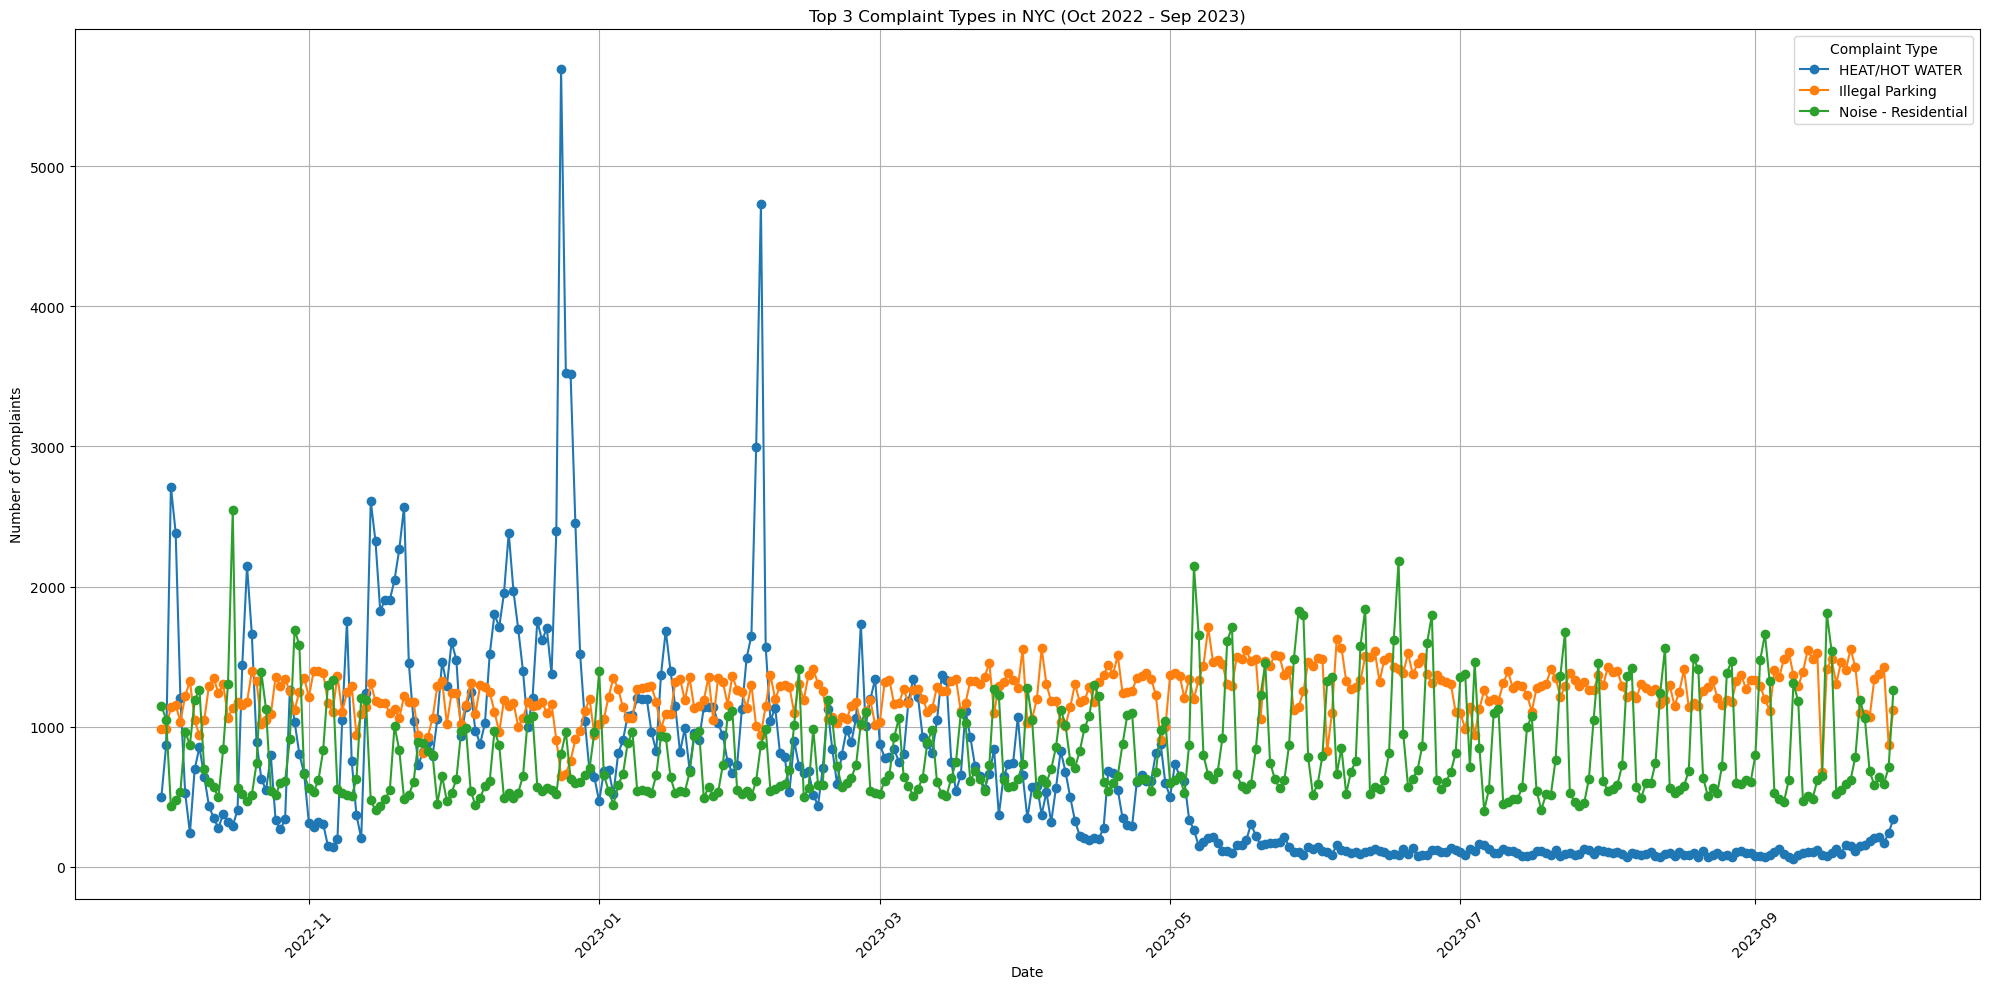

In [63]:
# Retrieve the data and plot it
complaints_data = get_data_for_visual_1()
plot_visual_1(complaints_data)

### Result
- HEAT/HOT WATER, Illegal Parking, and Noise - Residential are the most reported complaint types.
- Seasonal trends can be observed, with heating complaints peaking in the colder months.
- The visualization highlights the ongoing urban challenges in managing residential noise and parking.
- The variance of noise complaint is obviously high when the weather is hot, and gradually lower when the weather is cold. 
- Complaints about illegal parking have been very stable throughout the year, indicating that it has always been a common problem.

### Visualization 2 What are the most common complaints in the immediate area?

Prevalent Complaints in Zip Code 10027

**Objective**: 
Display the most common complaint types within zip code 10027 from October 1st, 2018, to September 30th, 2023.

**Visualization Description**:
A bar chart that ranks the top 10 complaint types by frequency, providing a clear picture of the primary concerns reported by residents in the area.


In [67]:
def get_data_for_visual_2(zipcode=10027, start_date='2018-10-01', end_date='2023-09-30'):
    """
    Queries the database for the data needed for visual 2.

    Args:
        - zipcode (int): The zipcode to filter the complaints by.
        - start_date (str): The start date of the period to consider.
        - end_date (str): The end date of the period to consider.

    Returns:
        DataFrame: A pandas DataFrame containing the data needed for the plot.
    """
    # SQL query to get the top 10 complaint types for a specific zipcode within the date range
    complaints_by_type_sql = f"""
    SELECT complaint_type, COUNT(*) as count
    FROM complaint
    WHERE date BETWEEN %(start_date)s AND %(end_date)s
    AND zipcode = %(zipcode)s
    GROUP BY complaint_type
    ORDER BY count DESC
    LIMIT 10;
    """
    
    complaints_by_type_df = pd.read_sql_query(
        complaints_by_type_sql, 
        engine, 
        params={'zipcode': zipcode, 'start_date': start_date, 'end_date': end_date}
    )
    
    return complaints_by_type_df.set_index('complaint_type')


In [68]:
def plot_visual_2(dataframe,zipcode):
    """
    Plots the data from the dataframe as a bar chart.

    Args:
        dataframe (DataFrame): DataFrame containing the data to plot.
    """
    dataframe.plot(kind='bar', figsize=(12, 6), color='teal')
    plt.title(f'Top 10 Complaint Types in Zip Code {zipcode} (Oct 2018 - Sep 2023)')
    plt.xlabel('Complaint Type')
    plt.ylabel('Number of Complaints')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

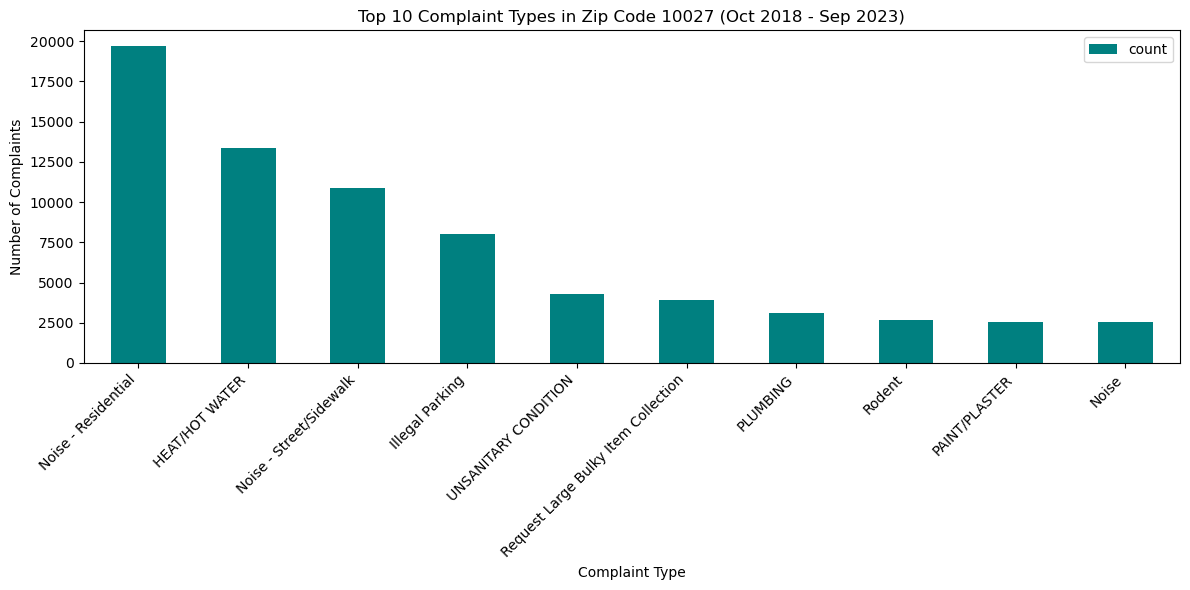

In [71]:
# Retrieve the data for a specific zipcode and plot it
zipcode_data = get_data_for_visual_2(zipcode=10027, start_date='2018-10-01', end_date='2023-09-30')
plot_visual_2(zipcode_data,zipcode=10027)

### Result
- The chart illustrates the prevalence of issues like Noise - Residential, HEAT/HOT WATER, and Illegal Parking.
- It offers a visual representation of community-reported issues over the five-year span.
- As can be seen from the chart, the biggest living demand of residents living in area 10027 is to reduce noise.


### Visualization 3 Is there any correlation between rent, trees, and complaints at all?

Rent, Trees, and Complaints Correlation

**Objective**: 
Explore possible correlations between average rent prices, tree counts, and 311 complaint counts by zip code over an extensive period.

**Visualization Description**:
Two scatter plot subplots sharing the x-axis are created. The top subplot compares the average rent to the number of trees per zip code, while the bottom subplot compares the average rent to the number of complaints per zip code.

In [72]:
def get_data_for_visual_3(start_date, end_date):
    # SQL queries to get the required data
    rent_sql = f"""
    SELECT zipcode, AVG(rent) as average_rent
    FROM zillow
    WHERE date BETWEEN %(start_date)s AND %(end_date)s
    GROUP BY zipcode;
    """

    tree_sql = f"""
    SELECT zipcode, COUNT(*) as tree_count
    FROM tree
    WHERE date BETWEEN %(start_date)s AND %(end_date)s
    GROUP BY zipcode;
    """

    complaint_sql = f"""
    SELECT zipcode, COUNT(*) as complaint_count
    FROM complaint
    WHERE date BETWEEN %(start_date)s AND %(end_date)s
    GROUP BY zipcode;
    """
    
    # Execute the queries and store in DataFrames
    rent_df = pd.read_sql_query(rent_sql, engine, params={'start_date': start_date, 'end_date': end_date})
    tree_df = pd.read_sql_query(tree_sql, engine, params={'start_date': start_date, 'end_date': end_date})
    complaint_df = pd.read_sql_query(complaint_sql, engine, params={'start_date': start_date, 'end_date': end_date})
    
    # Merge the DataFrames on the zipcode
    merged_data = rent_df.merge(tree_df, on='zipcode').merge(complaint_df, on='zipcode')
    return merged_data



In [73]:
def visualize_rent_trees_complaints_correlation(data, start_date, end_date):
    # Create a figure and a set of subplots with shared x-axis
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

    # First subplot: Rent vs. Trees
    ax1.scatter(data['average_rent'], data['tree_count'], color='green')
    ax1.set_ylabel('Number of Trees')
    ax1.set_title('Rent vs. Number of Trees by Zip Code')

    # Second subplot: Rent vs. Complaints
    ax2.scatter(data['average_rent'], data['complaint_count'], color='red')
    ax2.set_ylabel('Number of Complaints')
    ax2.set_xlabel('Average Rent')
    ax2.set_title('Rent vs. Number of Complaints by Zip Code')

    # Display the plot
    plt.tight_layout()
    plt.show()


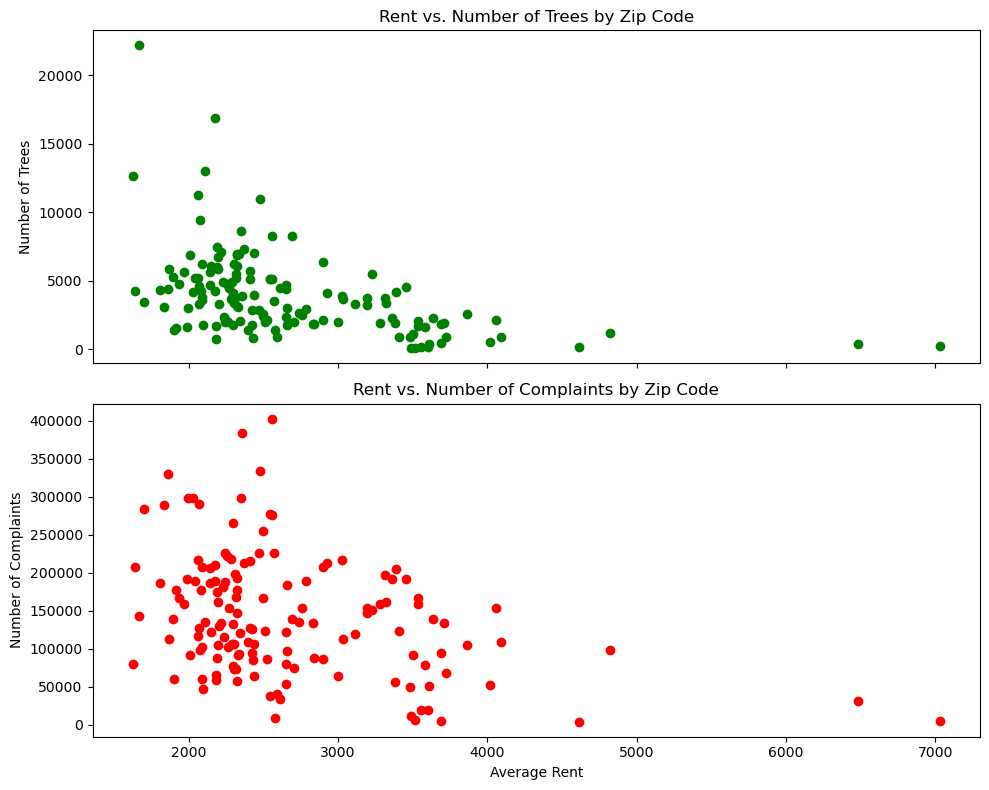

In [74]:
# Get the merged data
merged_data = get_data_for_visual_3('2015-01-01', '2023-09-30')

# Visualize the data
visualize_rent_trees_complaints_correlation(merged_data, '2015-01-01', '2023-09-30')

**Result**:
- The visualizations provide an at-a-glance comparison of how greenery and urban issues correlate with the cost of living in different neighborhoods.
- Rent vs. Number of Trees by Zip Code:The top scatter plot does not show a clear, strong correlation between higher rents and a greater number of trees. While some high-rent areas also have a high number of trees, there are also high-rent areas with fewer trees.There is a cluster of zip codes with moderate rent levels that have a wide range of tree counts, suggesting that other factors besides rent may influence the number of trees in an area.
- Rent vs. Number of Complaints by Zip Code:The bottom scatter plot indicates a more scattered distribution with no clear trend between the average rent and the number of complaints. This suggests that the frequency of complaints is not directly related to the rent levels.Some high-rent areas have a high number of complaints, while others have fewer, which may imply that factors other than rent influence complaint frequency.

### Visualization 4 If I can afford more in rent, will there be fewer issues & complaints?

Rent Affordability vs. Neighborhood Complaints

**Objective**: 
Examine if higher rent districts experience fewer 311 complaints, suggesting possibly better living conditions.

**Visualization Description**:
A boxplot where average rents for September 2023 are categorized into $1000

In [78]:
def get_rent_complaints_data_for_boxplot(rent_date, complaint_start_date, complaint_end_date):
    rent_sql = """
    SELECT zipcode, AVG(rent) as average_rent
    FROM zillow
    WHERE date = %(rent_date)s
    GROUP BY zipcode;
    """

    complaints_sql = """
    SELECT zipcode, COUNT(*) as complaints_count
    FROM complaint
    WHERE date >= %(complaint_start_date)s AND date <= %(complaint_end_date)s
    GROUP BY zipcode;
    """
    
    rent_data = pd.read_sql_query(rent_sql, engine, params={'rent_date': rent_date})
    complaints_data = pd.read_sql_query(complaints_sql, engine, params={'complaint_start_date': complaint_start_date, 'complaint_end_date': complaint_end_date})
    
    # Merge the DataFrames on the zipcode
    merged_data = pd.merge(rent_data, complaints_data, on='zipcode', how='inner')
    
    # Ensure bins are consistent with the original method
    max_rent = merged_data['average_rent'].max()
    # Set the range to cover up to the maximum rent plus a bit more
    bins = list(range(0, int(max_rent) + 1000, 1000))
    merged_data['rent_bin'] = pd.cut(merged_data['average_rent'], bins=bins, right=False)
    
    return merged_data

In [79]:
def plot_boxplot_for_rent_vs_complaints(merged_data):
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='rent_bin', y='complaints_count', data=merged_data)
    plt.title('Number of 311 Complaints vs. Average Rent (Sep 2023)')
    plt.xlabel('Average Rent in September 2023 ($1000 bins)')
    plt.ylabel('Number of 311 Complaints')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


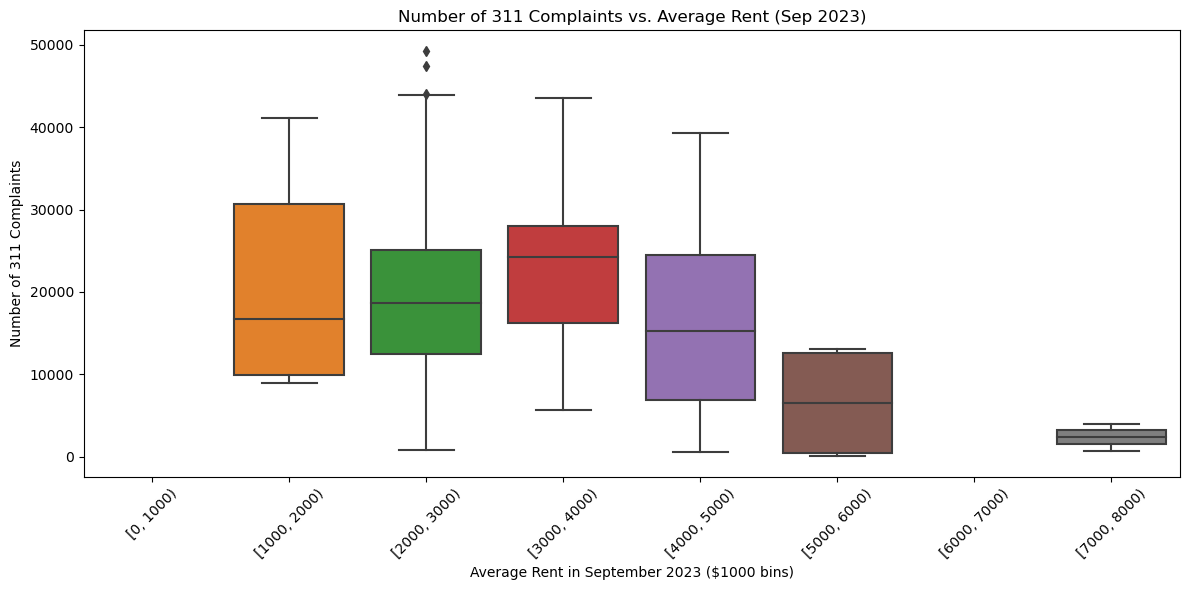

In [80]:
# Define the dates for rent and complaints data
rent_date = '2023-09-30'
complaint_start_date = '2022-10-01'
complaint_end_date = '2023-09-30'

# Retrieve and plot the data
data_for_boxplot = get_rent_complaints_data_for_boxplot(rent_date, complaint_start_date, complaint_end_date)
plot_boxplot_for_rent_vs_complaints(data_for_boxplot)


### Result

Analysis of Boxplot:

- There does not appear to be a clear, consistent trend indicating that higher rents are associated with fewer 311 complaints.
- Some higher rent bins exhibit a wide range of complaint numbers, suggesting variability within these rent categories.
- A few high rent bins show a lower median number of complaints, which could indicate a tendency towards fewer issues in certain higher rent areas. However, the presence of outliers with high complaint numbers suggests exceptions to this potential trend.
- Lower rent bins also display variability, with some bins having higher medians and wide spreads, indicating that rent level alone may not be a reliable predictor of the frequency of neighborhood complaints.

